# Introdução

O objetivo desse notebook é realizar um estudo sobre tendências e pontos de virada em séries temporais. Para isso, usaremos como dados as informações sobre casos e óbitos por covid no estado do Ceará. 
Confira o [repositório do projeto no Github](https://github.com/renanmath/Bootcamp_Projeto_Modulo03).

Grosso modo, podemos dizer que uma série temporal apresenta três grandes padrões de tendência, bem autoexplicativos:
- Tendência de alta
- Tendência de baixa
- Tendência estacionária ou lateralizada

Obviamente, estando em qualquer uma dessas tendências, a série pode oscilar para cima ou para baixo. A esse fenômeno chamamos de volatilidade. Existem séries temporais mais voláteis, outras menos voláteis. E existem métricas ou indicadores que mensuram a volatilidade.

É claro também que a tendência de uma série depende da janela de tempo que estamos considerando. Como dito acima, cada ciclo de alta/baixa/lateralização é formada por ciclos menores. Em uma janela de tempo de um mês, por exemplo, podemos observar uma tendência de baixa, enquanto que se considerarmos a série anualmente, ela está em tendência de alta. 

Independente disso, reversões de tendência ocorrem, e podemos utilizar alguns sinais para saber (com certa precisão, em geral atrasada) quando ocorrem. Esses momentos onde temos uma mudança da tendência chamamos de pontos de virada (*change points*). 

Nesse notebook vamos estudar três ferramentas que auxiliam na identficação de tendências:

**Derivada (discreta)**

A derivada é um conceito do cálculo diferencial. Grosso modo, é uma função que mede a taxa de variação de outra função. No caso de séries temporais, por estarmos lidando com dados discretos, esse conceito não se aplica ipsis litteris. No entanto, o conceito de taxa de variação média é conhecido, e isso é apenas outro nome para a chamada derivada discreta. 

Em cálculo diferencial, é conheido o seguinte resultado: pontos de máximo e mínimo locais tem derivada nula. Sabemos também que, com hipóteses razoáveis sobre a função, em pontos de máximo e mínimo temos reversão de tendência (crescente para decrescente ou vice-versa). 

Então faz sentido utilizar algo semelhante para estimar a localização de pontos de virada em séries temporais.

**Indicador SuperTrend**

Utilizado no mercado de ações, esse é um indicador do tipo bandas. Ele acompanha a tendência geral de uma série temporal, mas estabelece bandas inferior e superior, que podem ser intepretadas como suporte e resistência. Se a série cruza uma banda superior para cima, ele rompe a resistência e o que se espera é que entre em tendência de alta. Por outro lado, se a série cruza a banda inferior para baixo, espera-se uma tendência de baixa.

Nesse projeto, vamos adaptar esse indicador para as séries que temos. 

**Cruzamento de médias móveis**

Médias móveis são um tipo de indicador seguidor de tendência. Como o próprio nome diz, elas acompanham a série temporal, tentando mensurar a tendência geral da mesma. Mas as médias móveis podem ter diferentes períodos. Aquelas com períodos mais curtos tendem a ter maior volatilidade, sendo bem próximas da série original. Já as de período mais longo tendem a ser mais suaves, ditanto uma tendência de longo prazo da série. 
Médias móveis mais curtas são mais sensíveis a mudanças de tendência. Séries longas são menos sensíveis e só revertem quando a mudança de tendência é realmente forte. 
A mágica acontece quando elas se cruzam. A leitura é a seguinte:
- Média curta cruzando a média longa para cima ---> indicação de início de tendência de alta.
- Média curta cruzando a média longa para baixo ---> indicação de início de tendência de baixa.


Além disso, vamos explorar também as **aproximações poligonais**. É uma maneira bem visual de ver os pontos de virada. Após identificar esses pontos no gráfico da série temporal, ligamos esses pontos por linhas retas. 
A inclinação dessas retas pode ser uma forma de mensurar a taxa de crescimento (ou descrescimento) entre dois pontos de virada. 

# Importação de bibliotecas e funções

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import warnings
import math
import datetime
import matplotlib.ticker as ticker
warnings.filterwarnings('ignore') #ignora os avisos

In [ ]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

In [ ]:
pd.options.display.float_format = "{:,.2f}".format

## Médias móveis

In [ ]:
def media_movel(serie_temporal, periodos = 7):
  serie = serie_temporal.copy()
  n = len(serie)
  pe = periodos

  MM = []

  for i in range(0,pe):
    valor = sum(serie[0:i+1])/(i+1)
    MM.append(valor)

  for i in range(pe,n):
    valor = sum(serie[i-pe:i])/pe
    MM.append(valor)
  
  return MM

In [ ]:
def media_movel_exp(serie_temporal, periodos = 7):
  serie = serie_temporal.copy()
  n = len(serie)
  pe = periodos
  mu = 2/(pe+1)

  MME = [serie[0]]

  for i in range(1,n):
    valor = mu*(serie[i] - MME[i-1]) + MME[i-1]
    MME.append(valor)

  return MME

## Funções auxiliares

Função que identifica se houve uma mudança de sinal

In [ ]:
def var_sinal(serie_temporal, tolerancia = 3):
  serie = serie_temporal.tolist().copy()
  tl = tolerancia

  n = len(serie)
  variacao_sinal = [1]
  for i in range(1,tl):
    variacao_sinal.append(0)

  for i in  range(tl,n-1):
    mi = min(serie[i-tl:i])
    ma = max(serie[i-tl:i])
    if (serie[i]*mi < 0) & (serie[i] < 0) & (serie[i+1]  < 0) & (mi >  0) & (serie[i-1] > 0):
      variacao_sinal.append(-1)
    elif (serie[i]*ma < 0) & (serie[i] > 0) & (serie[i+1] > 0) & (ma < 0) & (serie[i-1] < 0):
      variacao_sinal.append(1)
    else:
      variacao_sinal.append(0)

  variacao_sinal.append(1)

  return variacao_sinal



Função que olha os deslocamentos futuros (ou passados) de uma série temporal e calculo alguma métrica. 

In [ ]:
def olhar_futuro(serie_temporal, periodos = 7, acao = 'max', perc = -1, epsilon = 1):
  serie = serie_temporal.copy()
  n = len(serie)
  ep = epsilon  
  serie.append(np.nan)
  pe = periodos
  serie_futura = []
  if pe == 0:
    return 'ERRO: período não pode ser zero'

  if pe > 0:
    if acao == 'max':
      for i in range(0,n):
        lsup = min([i+pe,n])
        valor = max(serie[i+ep:lsup+1])
        serie_futura.append(valor)

    elif acao == 'min':
      for i in range(0,n):
        lsup = min([i+pe,n])
        valor = min(serie[i+ep:lsup+1])
        serie_futura.append(valor)

    elif acao == 'soma':
      for i in range(0,n):
        lsup = min([i+pe,n])
        valor = sum(serie[i+ep:lsup+1])
        serie_futura.append(valor)
    
    elif acao == 'media':
      for i in range(0,n):
        lsup = min([i+pe,n])
        valor = sum(serie[i+ep:lsup+1])/len(serie[i+ep:lsup+1])
        serie_futura.append(valor)

    elif acao == 'percentil':
      if perc == -1:
        return 'ERRO: Percentil não definido'
      else:
        for i in range(0,n):
          lsup = min([i+pe,n])
          valor = np.percentile(serie[i+ep:lsup+1], perc)
          serie_futura.append(valor)

    else:
      return 'ERRO: função não reconhecida.'

  else:
    if ep == 0:
      serie_futura.append(serie[0])
    if acao == 'max':
      for i in range(1-ep,n):
        linf = max([i+pe,0])
        valor = max(serie[linf:i+ep])
        serie_futura.append(valor)

    elif acao == 'min':
      for i in range(1-ep,n):
        linf = max([i+pe,0])
        valor = min(serie[linf:i+ep])
        serie_futura.append(valor)

    elif acao == 'soma':
      for i in range(1-ep,n):
        linf = max([i+pe,0])
        valor = sum(serie[linf: i+ep])
        serie_futura.append(valor)
  
    elif acao == 'media':
      for i in range(1-ep,n):
        linf = max([i+pe,0])
        valor = sum(serie[linf:i+ep])/len(serie[linf:i+ep])
        serie_futura.append(valor)

    elif acao == 'percentil':
      if perc == -1:
        return 'ERRO: Percentil não definido'
      else:
        for i in range(1-ep,n):
          linf = max([i+pe,0])
          valor = np.percentile(serie[linf: i+ep], perc)
          serie_futura.append(valor)

    else:
      return 'ERRO: função não reconhecida.'

  return serie_futura


In [ ]:
exemplo = [1,2,-1,-1,0,3,5,4,-8,0,3,11,15,12,17,10,2,-7,-13,-9,-2,5,9,14,18,21,25, 20, 16, 17, 15, 19, 22,28,30,35,32,29,40,
           41,42,38,34,30,28,31,36,37,37,38,39,40,42,47,50,52,49,46, 40,36,32,27,25,20,19,17,13,9,4,-1,-3,-7,-13,-20,-15,-9,-2,4,5,5,4,3,0,-1,3,7,10,9,
           12,20,25,32,35,30,29,27,36,40,50,55,57,63,67,72,69,65,64,61,63,66,70,73,77,81, 85, 90, 87, 92, 97, 101, 105,103,108, 106,
           108,109,112,114,120,126,132,146,121,119,115,117,118,117,119, 121,120,119,122,124,123,126,101,97,92,89,75, 20, 12, 14, 15, 11]

In [ ]:
len(olhar_futuro(exemplo, periodos= -3, acao= 'percentil', perc = 75, epsilon=0)), len(exemplo), 

(156, 156)

## Funções de pontos de virada (método da derivada discreta)

In [ ]:
def pontos_virada_derivada(dataset, variavel, nome_variavel, v_tempo = 'Data', periodos1 = 14, periodos2 = 14, tolerancia = 7):
  dados = pd.DataFrame()
  dados[v_tempo] = dataset[v_tempo]
  dados[variavel] = dataset[variavel]  
  pe1 = periodos1
  pe2 = periodos2
  tl = tolerancia
  
  dados['var1_'+nome_variavel] = dados[variavel].diff(periods = pe1)/pe1
  dados['var2_'+nome_variavel] = dados['var1_'+nome_variavel].diff(periods = pe2)/pe2
  dados['change_point_derivada'] = [abs(ele) for ele in var_sinal(dados['var2_'+nome_variavel], tolerancia=tl)]

  return dados

In [ ]:
def plotar_pontos_virada(dataset,  variavel, nome_variavel, titulo, v_tempo = 'Data', periodos1 = 14, periodos2 = 14, tolerancia = 7, mostrar_derivadas = False,
                         fator1 = 150, fator2 = 1000):
  df = dataset.copy()
  var = variavel
  n_var = nome_variavel
  temp = v_tempo
  pe1 = periodos1
  pe2 = periodos2
  tl = tolerancia
  f1 = fator1
  f2 = fator2
  dados = pontos_virada_derivada(dataset=df, variavel= var, nome_variavel= n_var, periodos1=pe1, periodos2= pe2, tolerancia= tl)

  vetor = dados[dados['change_point_derivada'] > 0][temp]
  plt.figure(figsize = (16,6))
  plt.plot(dados[temp], dados[variavel], color = 'navy')
  plt.title(titulo, fontdict={'fontsize':16, 'fontweight':'bold'})
  plt.xlabel('Período', fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.ylabel(n_var, fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.xticks(rotation = 90)
  plt.grid(axis = 'y', linestyle = '--')
  if mostrar_derivadas:
    plt.plot(dados[temp], f1*dados['var1_'+n_var], color = 'olive', alpha = 0.8)
    plt.plot(dados[temp], f2*dados['var2_'+n_var], color = 'salmon', alpha = 0.8)
    plt.legend([n_var, 'Primeira derivada', 'Segunda derivada', 'Pontos de virada'], loc = 'upper left')
    plt.axhline(0, linewidth = 1, color = 'r')
  for c in vetor.tolist():
    plt.axvline(c, linewidth=1.3, linestyle = '--', color = 'sienna')
  plt.show()

In [ ]:
def plotar_aproximacao_poligonal(dataset,  variavel, nome_variavel, titulo, v_tempo = 'Data', periodos1 = 14, periodos2 = 14, tolerancia = 7):
  df = dataset.copy()
  var = variavel
  n_var = nome_variavel
  temp = v_tempo
  pe1 = periodos1
  pe2 = periodos2
  tl = tolerancia
  dados = pontos_virada_derivada(dataset=df, variavel= var, nome_variavel= n_var, periodos1=pe1, periodos2= pe2, tolerancia= tl)

  indices_virada = dados[dados['change_point_derivada'] >0].index.tolist()
  lista = dados['change_point_derivada'].tolist()
  incrementos = []
  n = dados.shape[0]

  for j in range(1,n):
    if lista[j]==1:
      primeira_quebra = j
      break

  prox_atual = primeira_quebra
  ant_atual = 0
  valor_final_atual = lista[primeira_quebra]
  valor_inicial_atual = lista[0]
 
  for i in range(0,n):
    if lista[i] == 1:
      ant_atual = i
      valor_temp = dados.iloc[i][var]
      for j in range(i+1,n):      
        if lista[j] == 1:
          prox_atual = j
          valor_final = dados.iloc[j][var]
          valor_final_atual = valor_final
          valor_inicial = dados.iloc[i][var]
          valor_inicial_atual = valor_inicial
          incremento = (valor_final - valor_inicial)/(j-i)
          incrementos.append(valor_inicial + incremento)
          break
    else:
      valor_final = dados.iloc[prox_atual][var]
      valor_inicial = dados.iloc[ant_atual][var]
      valor = dados.iloc[i][var]
      incremento = (valor_final_atual - valor_inicial_atual)/(prox_atual-ant_atual)
      incrementos.append(valor_inicial_atual + (i-ant_atual)*incremento)

  vetor = dados[dados['change_point_derivada'] > 0][temp]

  plt.figure(figsize = (16,6))
  plt.plot(dados[temp], dados[variavel], color = 'royalblue')
  plt.title(titulo, fontdict={'fontsize':16, 'fontweight':'bold'})
  plt.xlabel('Período', fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.ylabel(n_var, fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.xticks(rotation = 90)
  plt.grid(axis = 'y', linestyle = '--')
  plt.plot(dados[temp][0:len(incrementos)],incrementos, color = 'chocolate', linewidth = 1.8)
  for c in vetor.tolist():
    plt.axvline(c, linewidth=0.7, linestyle = '--', color = 'olive') 

## Funções do SuperTrend

In [ ]:
def TR_func(serie_temporal, unidade = 4):
  serie = serie_temporal.copy()
  n = len(serie)
  un = unidade
  if un <=0:
    print('ERRO: unidade deve ser um inteiro positivo')
    return False

  lista_TR = []
  lista_max = olhar_futuro(serie, periodos = -un, acao= 'max', epsilon=1)
  lista_min = olhar_futuro(serie, periodos = -un, acao= 'min', epsilon=1)
  lista_md = olhar_futuro(serie, periodos = -un, acao= 'media', epsilon=1)

  lista_TR.append(serie[0])
  for i in range(1,n):
    ind = max(0,i-un-1)
    v1 = lista_max[i] - serie[ind]
    v2 = lista_min[i] - serie[ind]
    v3 = lista_max[i] - lista_min[i]
    valor = max([v1,v2,v3])
    lista_TR.append(valor)

  return lista_TR


In [ ]:
def ATR_func(serie_temporal, periodos = 7, unidade = 4):
  serie = serie_temporal.copy()
  pe = periodos
  un = unidade
  TR = TR_func(serie,unidade = un)
  #lista_ATR = TR[0:abs(pe)]
  lista_ATR = media_movel_exp(TR[0:abs(pe)], periodos= un)
  n = len(serie)  

  for i in range(abs(pe),n):
    atual = lista_ATR[-1]
    novo = (atual*(abs(pe) -1)+ TR[i])/abs(pe)
    lista_ATR.append(novo)
  
  return lista_ATR


In [ ]:
def supertrend(serie_temporal, periodos = 7, unidade = 4, multiplicador1 = 1.5, multiplicador2 = 1.5):
  serie = serie_temporal.copy()
  pe = periodos
  mu1 = multiplicador1
  mu2 = multiplicador2
  un = unidade
  serie_max = olhar_futuro(serie, periodos= pe, acao= 'max')
  serie_min = olhar_futuro(serie, periodos= pe, acao= 'min')
  serie_TR = ATR_func(serie, periodos= pe, unidade=un)

  #lista_m_TR = [mult*valor for valor in serie_TR]
  upper_trend = [x + mu1*y for x, y in zip(serie, serie_TR)]
  low_trend = [x - mu2*y for x, y in zip(serie, serie_TR)]

  final_up = []
  if math.isnan(upper_trend[0]) == True:
    final_up.append(0)
  else:
    final_up.append(upper_trend[0])  
  for i in range(1,len(upper_trend)):
    if (serie[i-1] >= final_up[i-1]): #and  (upper_trend[i] > final_up[i-1]) and :
      final_up.append(upper_trend[i])
    else:
      final_up.append(final_up[i-1])
    

  final_low = []
  if math.isnan(low_trend[0]) == True:
    final_low.append(0)
  else:
    final_low.append(low_trend[0])
  for i in range(1,len(low_trend)):
    if (serie[i-1] <= final_low[i-1]): #and (low_trend[i] < final_low[i-1]) and :
      final_low.append(low_trend[i])
    else:
      final_low.append(final_low[i-1])    

  return final_up, final_low, upper_trend, low_trend

In [ ]:
def plotar_supertrend(dataset, variavel, titulo, v_tempo = 'Data',periodos = -7, unidade = 4,
                      multiplicador1 = 1.5, multiplicador2 = 1.5, mostrar_bandas_basicas = False):
  pe = periodos
  mu1 = multiplicador1
  mu2 = multiplicador2
  un = unidade
  dados = dataset.copy()
  banda_sup, banda_inf, basic_up,basic_low = supertrend(dados[variavel].tolist(), periodos=pe, unidade = un,
                                                        multiplicador1=mu1, multiplicador2 = mu2)

  plt.figure(figsize=(16,6))
  sns.lineplot(x = dados[v_tempo], y = banda_sup, color = 'r')
  sns.lineplot(x = dados[v_tempo], y = banda_inf, color = 'seagreen')
  sns.lineplot(x = dados[v_tempo], y = dados[variavel], color = 'b', linewidth= 2)
  if mostrar_bandas_basicas == True:
    sns.lineplot(x = dados[v_tempo], y = basic_up, color = 'brown', alpha = 0.8)
    sns.lineplot(x = dados[v_tempo], y = basic_low, color = 'olive', alpha = 0.8)

  plt.suptitle('SuperTrend de ' +  str(pe) + ' períodos', 
            fontdict={'fontsize':15, 'fontweight':'bold'})
  plt.title(titulo,
               fontdict={'fontsize':14, 'fontweight':'bold'})
  plt.xlabel('Data', fontdict={'fontsize':12, 'fontweight':'bold'})
  plt.ylabel('SuperTrend', fontdict={'fontsize':12, 'fontweight':'bold'})
  plt.grid(linestyle = '--')
  plt.show()


## Funções de cruzamento de médias móveis

In [ ]:
def cruzar_series(serie_temporal1, serie_temporal2):
  serie1 = serie_temporal1.copy()
  serie2 = serie_temporal2.copy()

  if len(serie1) != len(serie2):
    return 'As séries temporais devem ter mesmo comprimento'

  cruzar = [1]
  n = len(serie1)
  
  for i in range(1,n-1):
    if (serie1[i-1] <= serie2[i-1]) and (serie1[i]> serie2[i]):
      cruzar.append(1)
    elif (serie1[i-1] >= serie2[i-1]) and (serie1[i] < serie2[i]):
      cruzar.append(-1)
    else:
      cruzar.append(0)
  cruzar.append(1)
  return cruzar

In [ ]:
def cruzar_medias_moveis(dataset, variavel, titulo, tipo = 'exponencial', v_tempo = 'Data', periodo1 = 7, periodo2 = 14):
  dados = dataset.copy()
  pe1 = periodo1
  pe2 = periodo2

  if pe1 >= pe2:
    return 'O primeiro período deve ser menor que o segundo período'

  if pe1*pe2 <= 0:
    return 'Períodos devem ser positivos'

  if tipo == 'exponencial':
    MM1 = media_movel_exp(dados[variavel].tolist(), periodos= pe1)
    MM2 = media_movel_exp(dados[variavel].tolist(), periodos= pe2)
  elif tipo == 'simples':
    MM1 = media_movel(dados[variavel].tolist(), periodos= pe1)
    MM2 = media_movel(dados[variavel].tolist(), periodos= pe2)
  else:
    return 'Tipos possíveis são "simples" e "exponencial"'
  
  dados['Média móvel curta'] = MM1
  dados['Média móvel longa'] = MM2
  cruzamento = cruzar_series(MM1,MM2)
  dados['Cruzamento'] = cruzamento
  
  plt.figure(figsize=(16,6))
  sns.lineplot(x = dados[v_tempo], y = MM1, color = 'r')
  sns.lineplot(x = dados[v_tempo], y = MM2, color = 'seagreen')
  sns.lineplot(x = dados[v_tempo], y = dados[variavel], color = 'b', linewidth= 2)
  vetor_p = dados[dados['Cruzamento'] > 0][v_tempo]
  vetor_n = dados[dados['Cruzamento'] < 0][v_tempo]

  for c in vetor_p.tolist():
    plt.axvline(c, linewidth=1.3, linestyle = '--', color = 'lime')
  for c in vetor_n.tolist():
    plt.axvline(c, linewidth=1.3, linestyle = '--', color = 'sienna')

  plt.suptitle('Cruzamento de médias móveis de ' +  str(pe1) +' e '+ str(pe2) + ' períodos', 
            fontdict={'fontsize':15, 'fontweight':'bold'})
  plt.title(titulo,
               fontdict={'fontsize':14, 'fontweight':'bold'})
  plt.xlabel('Data', fontdict={'fontsize':12, 'fontweight':'bold'})
  plt.ylabel(variavel, fontdict={'fontsize':12, 'fontweight':'bold'})
  plt.grid(linestyle = '--')
  plt.show()

In [ ]:
def plotar_aproximacao_poligonal_medias(dataset,  variavel, nome_variavel, titulo, tipo = 'exponencial', v_tempo = 'Data', periodo1 = 7, periodo2 = 14):
  dados = dataset.copy()
  var = variavel
  n_var = nome_variavel
  temp = v_tempo
  pe1 = periodo1
  pe2 = periodo2

  if pe1 >= pe2:
    return 'O primeiro período deve ser menor que o segundo período'

  if pe1*pe2 <= 0:
    return 'Períodos devem ser positivos'

  if tipo == 'exponencial':
    MM1 = media_movel_exp(dados[variavel].tolist(), periodos= pe1)
    MM2 = media_movel_exp(dados[variavel].tolist(), periodos= pe2)
  elif tipo == 'simples':
    MM1 = media_movel(dados[variavel].tolist(), periodos= pe1)
    MM2 = media_movel(dados[variavel].tolist(), periodos= pe2)
  else:
    return 'Tipos possíveis são "simples" e "exponencial"'
  
  dados['Média móvel curta'] = MM1
  dados['Média móvel longa'] = MM2
  cruzamento = cruzar_series(MM1,MM2)
  dados['Cruzamento'] = cruzamento
  
  

  indices_virada = dados[dados['Cruzamento']!= 0].index.tolist()
  incrementos = []
  n = dados.shape[0]
  lista = [abs(ele) for ele in cruzamento]

  for j in range(1,n):
    if lista[j]==1:
      primeira_quebra = j
      break

  prox_atual = primeira_quebra
  ant_atual = 0
  valor_final_atual = lista[primeira_quebra]
  valor_inicial_atual = lista[0]
 
  for i in range(0,n):
    if lista[i] == 1:
      ant_atual = i
      valor_temp = dados.iloc[i][var]
      for j in range(i+1,n):      
        if lista[j] == 1:
          prox_atual = j
          valor_final = dados.iloc[j][var]
          valor_final_atual = valor_final
          valor_inicial = dados.iloc[i][var]
          valor_inicial_atual = valor_inicial
          incremento = (valor_final - valor_inicial)/(j-i)
          incrementos.append(valor_inicial + incremento)
          break
    else:
      valor_final = dados.iloc[prox_atual][var]
      valor_inicial = dados.iloc[ant_atual][var]
      valor = dados.iloc[i][var]
      incremento = (valor_final_atual - valor_inicial_atual)/(prox_atual-ant_atual)
      incrementos.append(valor_inicial_atual + (i-ant_atual)*incremento)

  vetor = dados[dados['Cruzamento'] != 0][temp]

  plt.figure(figsize = (16,6))
  plt.plot(dados[temp], dados[variavel], color = 'royalblue')
  plt.title(titulo, fontdict={'fontsize':16, 'fontweight':'bold'})
  plt.xlabel('Data', fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.ylabel(n_var, fontdict={'fontsize':13, 'fontweight':'bold'})
  plt.xticks(rotation = 90)
  plt.grid(axis = 'y', linestyle = '--')
  plt.plot(dados[temp][0:len(incrementos)],incrementos, color = 'chocolate', linewidth = 1.8)
  for c in vetor.tolist():
    plt.axvline(c, linewidth=0.7, linestyle = '--', color = 'olive') 

# Importação e tratamento inicial dos dados

In [ ]:
colunas = ['Municipio',
           'Cod_IBGE',
           'Data',
           'Sem_epidemiologica',
           'Pop_estimada',
           'Pop_estimada_2019',
           'Ultimo?',
           'Repetido?',
           'Ultimos_confirmados',
           'Ultimos_confirmados_por_100k_habitantes',
           'Ultima_data',
           'Ultima_taxa_morte',
           'Ultimas_mortes',
           'Ordem_por_lugar',
           'Tipo_lugar',
           'Estado',
           'Novos_casos',
           'Novas_mortes'
           
           ]

In [ ]:
url = 'https://raw.githubusercontent.com/renanmath/Bootcamp_Projeto_Modulo03/main/dados/covid_CE'

In [ ]:
dados_geral = pd.read_csv(url)
dados_geral.drop('Unnamed: 0', axis = 1, inplace=True)
dados_geral.columns = colunas

In [ ]:
dados_geral

,Municipio,Cod_IBGE,Data,Sem_epidemiologica,Pop_estimada,Pop_estimada_2019,Ultimo?,Repetido?,Ultimos_confirmados,Ultimos_confirmados_por_100k_habitantes,Ultima_data,Ultima_taxa_morte,Ultimas_mortes,Ordem_por_lugar,Tipo_lugar,Estado,Novos_casos,Novas_mortes
0,Aquiraz,"2,301,000.00",2020-03-16,202012,"80,935.00","80,271.00",False,False,1,1.24,2020-03-16,0.00,0,1,city,CE,1,0
1,Fortaleza,"2,304,400.00",2020-03-16,202012,"2,686,612.00","2,669,342.00",False,False,8,0.30,2020-03-16,0.00,0,1,city,CE,8,0
2,NaN,23.00,2020-03-16,202012,"9,187,103.00","9,132,078.00",False,False,9,0.10,2020-03-16,0.00,0,1,state,CE,9,0
3,Aquiraz,"2,301,000.00",2020-03-17,202012,"80,935.00","80,271.00",False,False,1,1.24,2020-03-17,0.00,0,2,city,CE,0,0
4,Fortaleza,"2,304,400.00",2020-03-17,202012,"2,686,612.00","2,669,342.00",False,False,9,0.33,2020-03-17,0.00,0,2,city,CE,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79649,Uruoca,"2,313,906.00",2021-06-20,202125,"13,915.00","13,840.00",False,True,1426,"10,247.93",2021-06-19,0.02,31,428,city,CE,0,0
79650,Varjota,"2,313,955.00",2021-06-20,202125,"18,471.00","18,420.00",False,True,2279,"12,338.26",2021-06-19,0.01,27,413,city,CE,0,0
79651,Viçosa do Ceará,"2,314,102.00",2021-06-20,202125,"61,410.00","60,889.00",False,True,4788,"7,796.78",2021-06-19,0.03,140,428,city,CE,0,0
79652,Várzea Alegre,"2,314,003.00",2021-06-20,202125,"40,903.00","40,721.00",False,True,3076,"7,520.23",2021-06-19,0.02,66,438,city,CE,0,0


In [ ]:
dados_geral.dtypes


Municipio                                   object
Cod_IBGE                                   float64
Data                                        object
Sem_epidemiologica                           int64
Pop_estimada                               float64
Pop_estimada_2019                          float64
Ultimo?                                       bool
Repetido?                                     bool
Ultimos_confirmados                          int64
Ultimos_confirmados_por_100k_habitantes    float64
Ultima_data                                 object
Ultima_taxa_morte                          float64
Ultimas_mortes                               int64
Ordem_por_lugar                              int64
Tipo_lugar                                  object
Estado                                      object
Novos_casos                                  int64
Novas_mortes                                 int64
dtype: object

In [ ]:
dados_geral['Data'] = pd.to_datetime(dados_geral['Data'], format= '%Y-%m-%d')

In [ ]:
dados_geral

,Municipio,Cod_IBGE,Data,Sem_epidemiologica,Pop_estimada,Pop_estimada_2019,Ultimo?,Repetido?,Ultimos_confirmados,Ultimos_confirmados_por_100k_habitantes,Ultima_data,Ultima_taxa_morte,Ultimas_mortes,Ordem_por_lugar,Tipo_lugar,Estado,Novos_casos,Novas_mortes
0,Aquiraz,"2,301,000.00",2020-03-16,202012,"80,935.00","80,271.00",False,False,1,1.24,2020-03-16,0.00,0,1,city,CE,1,0
1,Fortaleza,"2,304,400.00",2020-03-16,202012,"2,686,612.00","2,669,342.00",False,False,8,0.30,2020-03-16,0.00,0,1,city,CE,8,0
2,NaN,23.00,2020-03-16,202012,"9,187,103.00","9,132,078.00",False,False,9,0.10,2020-03-16,0.00,0,1,state,CE,9,0
3,Aquiraz,"2,301,000.00",2020-03-17,202012,"80,935.00","80,271.00",False,False,1,1.24,2020-03-17,0.00,0,2,city,CE,0,0
4,Fortaleza,"2,304,400.00",2020-03-17,202012,"2,686,612.00","2,669,342.00",False,False,9,0.33,2020-03-17,0.00,0,2,city,CE,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79649,Uruoca,"2,313,906.00",2021-06-20,202125,"13,915.00","13,840.00",False,True,1426,"10,247.93",2021-06-19,0.02,31,428,city,CE,0,0
79650,Varjota,"2,313,955.00",2021-06-20,202125,"18,471.00","18,420.00",False,True,2279,"12,338.26",2021-06-19,0.01,27,413,city,CE,0,0
79651,Viçosa do Ceará,"2,314,102.00",2021-06-20,202125,"61,410.00","60,889.00",False,True,4788,"7,796.78",2021-06-19,0.03,140,428,city,CE,0,0
79652,Várzea Alegre,"2,314,003.00",2021-06-20,202125,"40,903.00","40,721.00",False,True,3076,"7,520.23",2021-06-19,0.02,66,438,city,CE,0,0


In [ ]:
dados_geral.dtypes

Municipio                                          object
Cod_IBGE                                          float64
Data                                       datetime64[ns]
Sem_epidemiologica                                  int64
Pop_estimada                                      float64
Pop_estimada_2019                                 float64
Ultimo?                                              bool
Repetido?                                            bool
Ultimos_confirmados                                 int64
Ultimos_confirmados_por_100k_habitantes           float64
Ultima_data                                        object
Ultima_taxa_morte                                 float64
Ultimas_mortes                                      int64
Ordem_por_lugar                                     int64
Tipo_lugar                                         object
Estado                                             object
Novos_casos                                         int64
Novas_mortes  

In [ ]:
dados_CE = dados_geral[dados_geral['Tipo_lugar'] == 'state']
dados_CE

,Municipio,Cod_IBGE,Data,Sem_epidemiologica,Pop_estimada,Pop_estimada_2019,Ultimo?,Repetido?,Ultimos_confirmados,Ultimos_confirmados_por_100k_habitantes,Ultima_data,Ultima_taxa_morte,Ultimas_mortes,Ordem_por_lugar,Tipo_lugar,Estado,Novos_casos,Novas_mortes
2,NaN,23.00,2020-03-16,202012,"9,187,103.00","9,132,078.00",False,False,9,0.10,2020-03-16,0.00,0,1,state,CE,9,0
5,NaN,23.00,2020-03-17,202012,"9,187,103.00","9,132,078.00",False,False,10,0.11,2020-03-17,0.00,0,2,state,CE,1,0
9,NaN,23.00,2020-03-18,202012,"9,187,103.00","9,132,078.00",False,False,19,0.21,2020-03-18,0.00,0,3,state,CE,9,0
14,NaN,23.00,2020-03-19,202012,"9,187,103.00","9,132,078.00",False,False,24,0.26,2020-03-19,0.00,0,4,state,CE,5,0
21,NaN,23.00,2020-03-20,202012,"9,187,103.00","9,132,078.00",False,False,68,0.74,2020-03-20,0.00,0,5,state,CE,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78909,NaN,23.00,2021-06-16,202124,"9,187,103.00","9,132,078.00",False,False,856267,"9,320.32",2021-06-16,0.03,21876,458,state,CE,3679,177
79095,NaN,23.00,2021-06-17,202124,"9,187,103.00","9,132,078.00",False,False,858502,"9,344.64",2021-06-17,0.03,21901,459,state,CE,2235,25
79281,NaN,23.00,2021-06-18,202124,"9,187,103.00","9,132,078.00",False,False,861688,"9,379.32",2021-06-18,0.03,21967,460,state,CE,3186,66
79467,NaN,23.00,2021-06-19,202124,"9,187,103.00","9,132,078.00",False,False,864529,"9,410.25",2021-06-19,0.03,22043,461,state,CE,2841,76


Criando as médias móveis

In [ ]:
dados_CE['MM7_casos_acumulados'] = media_movel(dados_CE['Ultimos_confirmados'].tolist(), periodos=7)
dados_CE['MM28_casos_acumulados'] = media_movel(dados_CE['Ultimos_confirmados'].tolist(), periodos=28)
dados_CE['MM7_obitos_acumulados'] = media_movel(dados_CE['Ultimas_mortes'].tolist(), periodos=7)
dados_CE['MM28_obitos_acumulados'] = media_movel(dados_CE['Ultimas_mortes'].tolist(), periodos=28)
dados_CE['MM7_casos_novos'] = media_movel(dados_CE['Novos_casos'].tolist(), periodos=7)
dados_CE['MM28_casos_novos'] = media_movel(dados_CE['Novos_casos'].tolist(), periodos=28)
dados_CE['MM7_obitos_novos'] = media_movel(dados_CE['Novas_mortes'].tolist(), periodos=7)
dados_CE['MM28_obitos_novos'] = media_movel(dados_CE['Novas_mortes'].tolist(), periodos=28)

Semana epidemiológica

Para uma discussão mais detalhada sobre semana epidemiológica, confira o primeiro notebok do projeto.

In [ ]:
dados_CE

,Municipio,Cod_IBGE,Data,Sem_epidemiologica,Pop_estimada,Pop_estimada_2019,Ultimo?,Repetido?,Ultimos_confirmados,Ultimos_confirmados_por_100k_habitantes,Ultima_data,Ultima_taxa_morte,Ultimas_mortes,Ordem_por_lugar,Tipo_lugar,Estado,Novos_casos,Novas_mortes,MM7_casos_acumulados,MM28_casos_acumulados,MM7_obitos_acumulados,MM28_obitos_acumulados,MM7_casos_novos,MM28_casos_novos,MM7_obitos_novos,MM28_obitos_novos
2,NaN,23.00,2020-03-16,202012,"9,187,103.00","9,132,078.00",False,False,9,0.10,2020-03-16,0.00,0,1,state,CE,9,0,9.00,9.00,0.00,0.00,9.00,9.00,0.00,0.00
5,NaN,23.00,2020-03-17,202012,"9,187,103.00","9,132,078.00",False,False,10,0.11,2020-03-17,0.00,0,2,state,CE,1,0,9.50,9.50,0.00,0.00,5.00,5.00,0.00,0.00
9,NaN,23.00,2020-03-18,202012,"9,187,103.00","9,132,078.00",False,False,19,0.21,2020-03-18,0.00,0,3,state,CE,9,0,12.67,12.67,0.00,0.00,6.33,6.33,0.00,0.00
14,NaN,23.00,2020-03-19,202012,"9,187,103.00","9,132,078.00",False,False,24,0.26,2020-03-19,0.00,0,4,state,CE,5,0,15.50,15.50,0.00,0.00,6.00,6.00,0.00,0.00
21,NaN,23.00,2020-03-20,202012,"9,187,103.00","9,132,078.00",False,False,68,0.74,2020-03-20,0.00,0,5,state,CE,44,0,26.00,26.00,0.00,0.00,13.60,13.60,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78909,NaN,23.00,2021-06-16,202124,"9,187,103.00","9,132,078.00",False,False,856267,"9,320.32",2021-06-16,0.03,21876,458,state,CE,3679,177,"841,261.71","806,123.11","21,432.00","20,623.82","3,392.86","3,665.46",50.00,84.04
79095,NaN,23.00,2021-06-17,202124,"9,187,103.00","9,132,078.00",False,False,858502,"9,344.64",2021-06-17,0.03,21901,459,state,CE,2235,25,"845,180.14","809,820.00","21,507.29","20,710.86","3,918.43","3,696.89",75.29,87.04
79281,NaN,23.00,2021-06-18,202124,"9,187,103.00","9,132,078.00",False,False,861688,"9,379.32",2021-06-18,0.03,21967,460,state,CE,3186,66,"848,502.71","813,380.50","21,581.86","20,790.61","3,322.57","3,560.50",74.57,79.75
79467,NaN,23.00,2021-06-19,202124,"9,187,103.00","9,132,078.00",False,False,864529,"9,410.25",2021-06-19,0.03,22043,461,state,CE,2841,76,"851,997.71","816,928.18","21,665.86","20,869.21","3,495.00","3,547.68",84.00,78.61


In [ ]:
dados_sem_CE = dados_CE.groupby(by = 'Sem_epidemiologica').sum()[['Ultimos_confirmados', 'Ultimas_mortes', 'Novos_casos', 'Novas_mortes']]
dados_sem_CE['Semana_epi'] = dados_sem_CE.index
dados_sem_CE['Semana_epi'] = pd.to_datetime(dados_sem_CE['Semana_epi'].astype(str)+'1', format= '%Y%W%w')
dados_sem_CE.drop([202125], inplace=True)
dados_sem_CE

,Ultimos_confirmados,Ultimas_mortes,Novos_casos,Novas_mortes,Semana_epi
Sem_epidemiologica,,,,,
202012,214,0,84,0,2020-03-23
202013,1526,10,238,4,2020-03-30
202014,3553,92,423,19,2020-04-06
202015,9258,365,923,51,2020-04-13
202016,16264,882,1394,106,2020-04-20
...,...,...,...,...,...
202120,5282856,136393,26625,725,2021-05-17
202121,5486009,140746,29859,629,2021-05-24
202122,5673519,144810,23889,463,2021-05-31


# Derivada discreta

Eu falei na introdução brevemente sobre a derivada discreta (ou taxa de variação) e como ela pode se relacionar com pontos de virada. Mas exatamente como? Podemos pensar os pontos de virada como os pontos onde a derivada muda de sinal, mas essa noção não é tão sutil quanto parece. Na verdade, parece mais razoável pensar um ponto de virada como um ponto onde a própria taxa de variação sofre uma mudança de tendência. Ou seja, queremos olhar para a taxa de variação da taxa de variação. Chamaremos isso de segunda taxa de variação (ou segunda derivada discreta). 

Sendo mais preciso, queremos identificar os momentos onde a segunda taxa de variação *muda de sinal*. Sendo bem resumido,isso é porque, se a taxa de variação de uma série é positiva, então a série está crescendo; se for negativa, então a série está decrescendo. Logo, se a segunda taxa de variação é positiva, então a taxa de variação está crescendo, ou seja, a série original está acelerando seu crescimento/descrescimento. E se a segunda taxa de variação for negativa, então a taxa de variação está descrecendo, ou seja, a série original está desacelerando o crescimento/descrescimento. Assim, os pontos onde seu sinal muda são os pontos onde a série original reverteu a tendência, de acelerar para desacelerar, ou vice-versa.

Isso é bem mais sutil do que simplesmente pensar nos pontos onde a série mudou de crescer para decrescer (ou vice-versa). Por que mudar a velocidade da taxa de crescimento também é uma mudança de tendência. Dependendo do problema ou da série temporal, isso pode parecer pouco relevante. Mas para as séries temporais dos casos de covid, ao meu ver, isso é muito relevante. Afinal, é de interessa saber se os casos estão crescento/decrescento mais rapidamente ou mais lentamente.

## Pontos de virada

Vejamos isso na prática. Vamos começar com os gráficos da função com os pontos de virada (e as derivadas indicadas também). Podemos mudar os hiperparâmetros da nossa função para melhor ajustar os pontos de virada.
Quanto maior os períodos das derivadas, mais suaves elas serão, portanto menos sensíveis a mudanças de tentência pontuais. Quanto maior a tolerância, menos sensível também a função será para captar variações bruscas pontuais. Por vezes, a segunda derivada irá oscilar de forma um tanto aleatória ao redor de zero em um curto perído de tempo, e isso pode causar falsas identificações de pontos de virada. Uma tolerância mais alta impede esse tipo de situação. Porém, se for muito alta, alguns pontos podem passar batidos. Por isso é imporante testar vários valores e visualmente verificar se o resultado está satisfatório. 

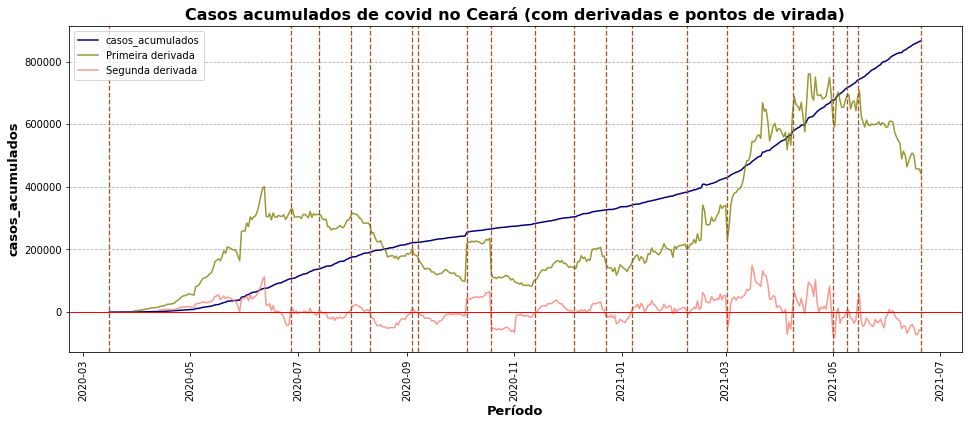

In [ ]:
plotar_pontos_virada(dataset=  dados_CE, variavel= 'Ultimos_confirmados', nome_variavel='casos_acumulados',
                    titulo = 'Casos acumulados de covid no Ceará (com derivadas e pontos de virada)', mostrar_derivadas=True,
                     periodos1 = 14, periodos2 = 14, tolerancia = 3)


Em alguns pontos é visualmente claro que identificamos corretamente um ponto de virada. Por exemplo, o ponto logo após 2021-03 é claramente um ponto de virada, pois observa-se que houve um súbido aumento na taxa de crescimento próximo a esse dia. Outros pontos de virada, entretanto, passaram batido pela função. Claramente deveríamos ter um em Maio de 2020, quando o crescimento dos casos explodiu. Entretanto, o método da segunda derivada não é capaz de captar esse tipo de mudança. Para isso, devemos utilizar outras técnicas. O SuperTrend em teoria seria capaz de identificar esse ponto, já que ele trabalha com bandas de suporte e resistência. 

Vejamos as outras variáveis.

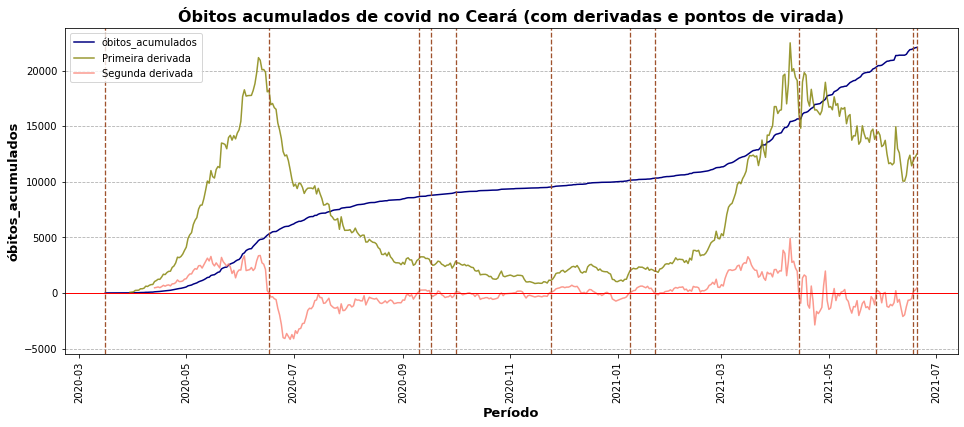

In [ ]:
plotar_pontos_virada(dataset=  dados_CE, variavel= 'Ultimas_mortes', nome_variavel='óbitos_acumulados',
                    titulo = 'Óbitos acumulados de covid no Ceará (com derivadas e pontos de virada)', mostrar_derivadas=True)

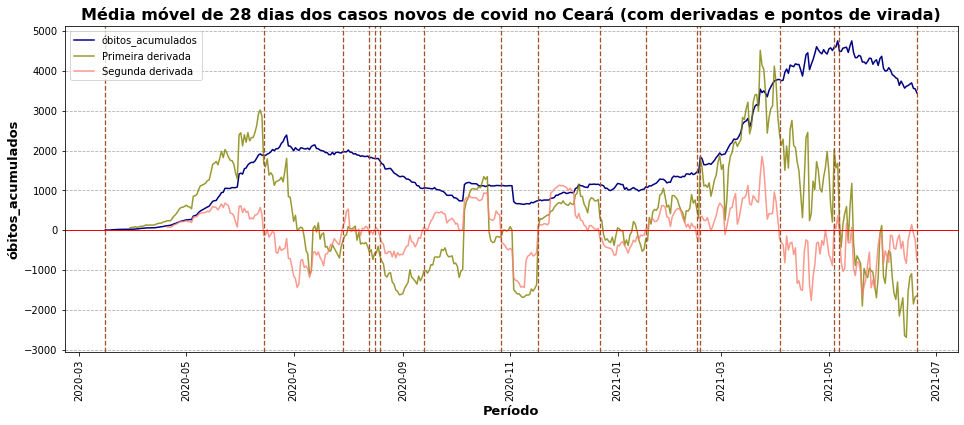

In [183]:
plotar_pontos_virada(dataset=  dados_CE, variavel= 'MM28_casos_novos', nome_variavel='óbitos_acumulados',
                    titulo = 'Média móvel de 28 dias dos casos novos de covid no Ceará (com derivadas e pontos de virada)', mostrar_derivadas=True,
                     periodos1 = 14, periodos2 = 21, tolerancia = 2, fator1 = 50, fator2 = 500)

Para esse gráfico, foi necessário ajustar os fatores das derivadas. Esses fatores não influenciam no cálculo das derivadas em si, apenas ajudam na visulização, alterando a escala dos valores para melhor se adequar aos valores dos dados originais. 

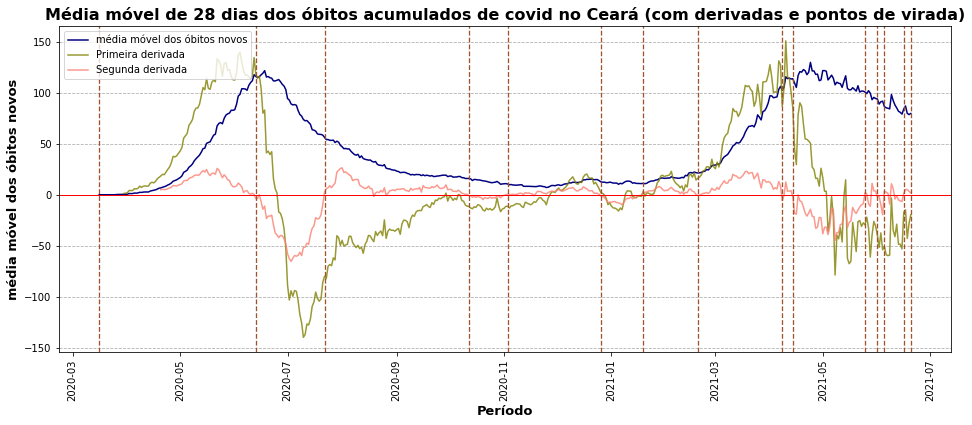

In [ ]:
plotar_pontos_virada(dataset=  dados_CE, variavel= 'MM28_obitos_novos', nome_variavel='média móvel dos óbitos novos',
                    titulo = 'Média móvel de 28 dias dos óbitos novos de covid no Ceará (com derivadas e pontos de virada)', mostrar_derivadas=True,
                     periodos1 = 14, periodos2 = 21, tolerancia = 3, fator1 = 50, fator2 = 300)

## Aproximações poligonais

Como dito antes, aproximações poligonais são boas para identificar visualmente as tendências: basta olhar para a inclinação das retas. É claro, podemos sempre visualizar mentalmente as retas sabendo onde estão os pontos de virada, mas ter as retas já desenhadas no gráfico facilita muito o processo. 
Vejamos como isso funciona com nossos dados:

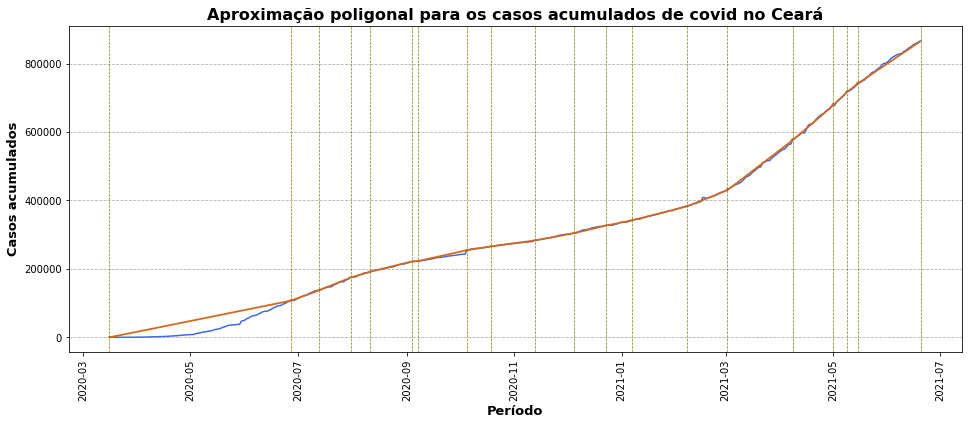

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'Ultimos_confirmados', 'Casos acumulados', 'Aproximação poligonal para os casos acumulados de covid no Ceará',
                             periodos1 = 14, periodos2 = 14, tolerancia = 3)

Observe como, nesse casos, as poligonais aproximam muito bem a série original. O mesmo ocorre para os óbitos acumulados:

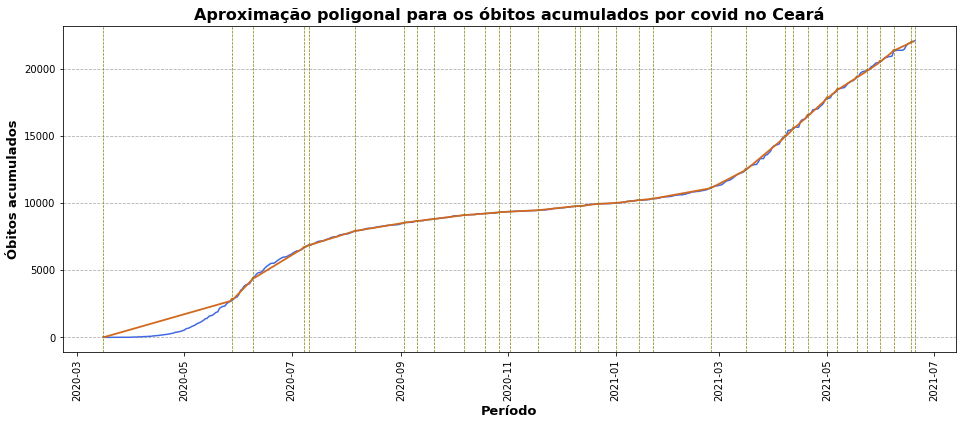

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'Ultimas_mortes', 'Óbitos acumulados', 'Aproximação poligonal para os óbitos acumulados por covid no Ceará',
                             periodos1 = 7, periodos2 = 7, tolerancia = 3)

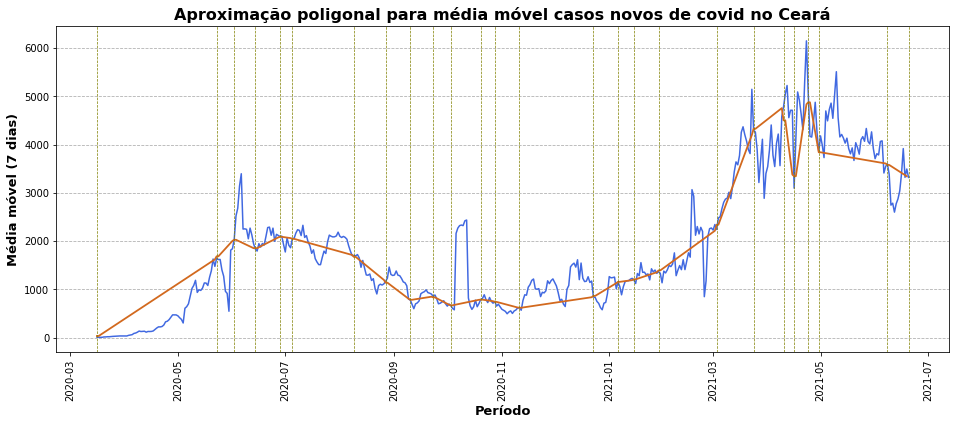

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'MM7_casos_novos', 'Média móvel (7 dias)', 'Aproximação poligonal para média móvel casos novos de covid no Ceará',
                             periodos1 = 14, periodos2 = 14, tolerancia = 5)

Aqui a aproximação já não é tão boa, mas é o suficiente para dar uma ideia razoável da tendência geral. E é exatamente essa a grande utilidade dessas aproximações: mostrar visulamente a tendência e onde ela muda. 
Observe que de Maio até Junho de 2021, houveram momentos de alta. Mas, segundo esse modelo, a tendência parece ser de baixa, como indicado pelas três últimas poligonais.
Quando olhamos a média móvel de 28 dias, fica ainda mais evidente: 

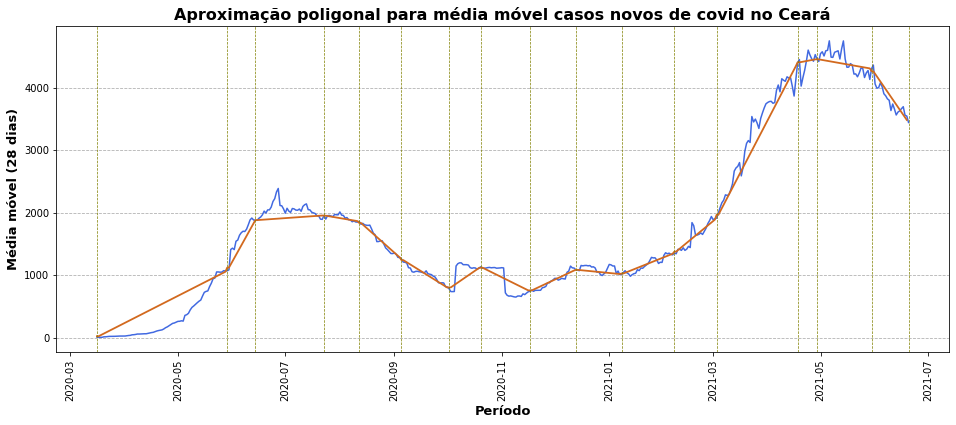

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'MM28_casos_novos', 'Média móvel (28 dias)', 'Aproximação poligonal para média móvel casos novos de covid no Ceará',
                             periodos1 = 14, periodos2 = 14, tolerancia = 7)

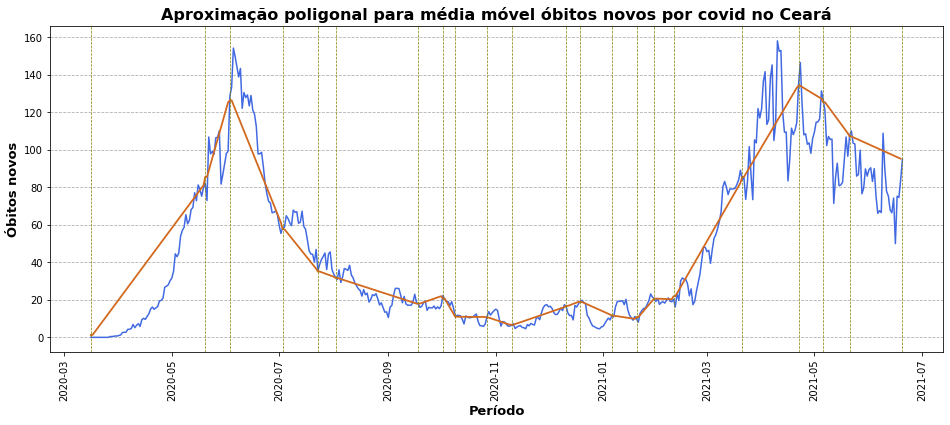

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'MM7_obitos_novos', 'Média móvel (7 dias)', 'Aproximação poligonal para média móvel óbitos novos por covid no Ceará',
                             periodos1 = 14, periodos2 = 14, tolerancia = 7)

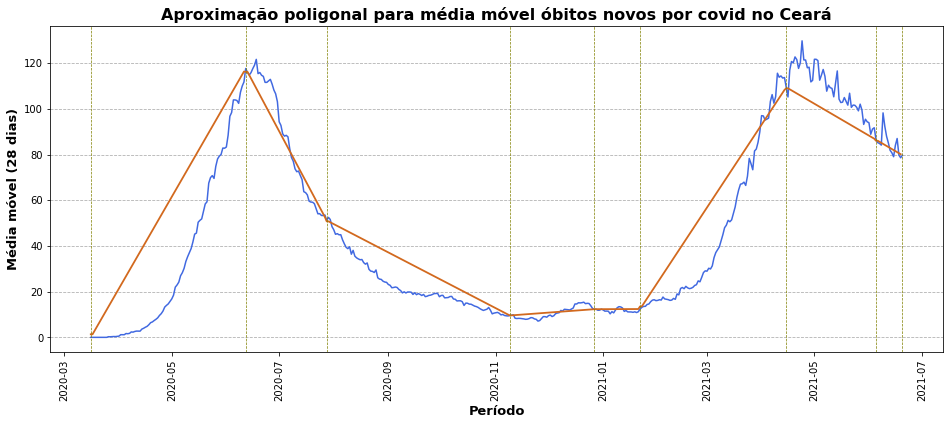

In [ ]:
plotar_aproximacao_poligonal(dados_CE, 'MM28_obitos_novos', 'Média móvel (28 dias)', 'Aproximação poligonal para média móvel óbitos novos por covid no Ceará',
                             periodos1 = 21, periodos2 = 21, tolerancia = 7)

Então sim, podemos afirmar que estamos,atualmente, em uma tendência de baixa no número de casos e óbitos novos diários por covid, no Ceará. Resta saber:
-  Por quanto tempo estaremos nessa tendência?
- Ela é uma tendência real, ou apenas consequencia de dados ainda não processados?

# Indicador SuperTrend

Nessa segunda abordagem, usaremos uma adaptação das bandas de SuperTrend. Ele é um indicador usando em análise técnica de gráficos de ações na bolsa de valores. Seu objetivo é tentar acompanhar as tendências de alta e baixa, e identificar quando houve uma mudança da tendência, demarcando regiões de compra e venda. Devido a essa sua característica de indentificar mudanças de tendência, achei válido adpatar sua fórmula para o nosso contexto. 

Deixo aqui algunas referências sobre esse indicador, que talvez ajudem a entender os códigos das funções, definidas na primeira sessão. 

https://www.quora.com/How-is-a-Supertrend-calculated

https://earnfo.com/supertrend-indicator/

https://www.thebalance.com/how-average-true-range-atr-can-improve-trading-4154923


No entanto, a ideia básica é simples: o indicador é formado por duas bandas que acompanham o gráfico, a banda superior (usualmente em vermelho) e a banda inferior (usualmente em verde). A banda superior funciona como uma resistência e a banda inferior, como um suporte. Quando o gráfico toca alguma das bandas, é indicação que poderemos ter uma reversão de tendência. 

Veja a figura abaixo

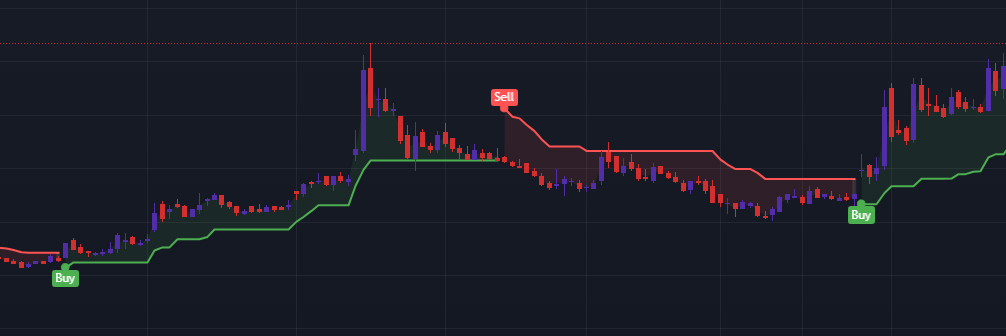

Na fórmula do SuperTrend é utilizada outra métrica: o ATR (Avenge True Range), que por sua vez é uma média do TR (True Range). Criamos funções que nos retornam esses valores (adaptados ao nosso contexto). Vejamos a análise usando as bandas de SupreTrend.

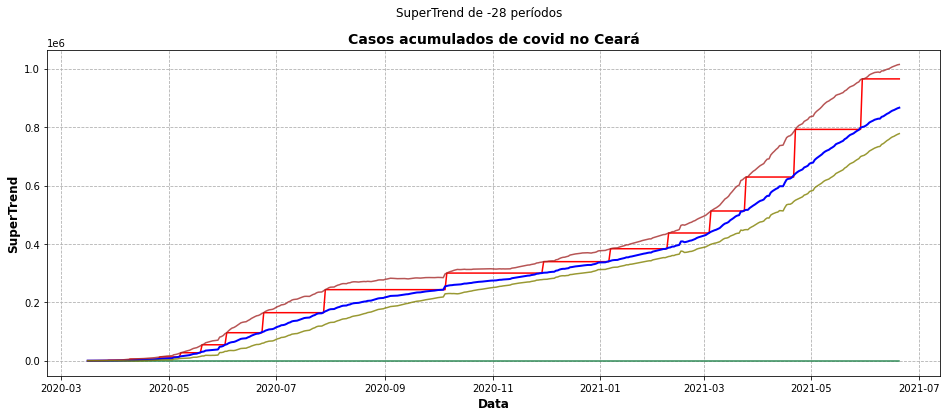

In [ ]:
plotar_supertrend(dados_CE, 'Ultimos_confirmados', 'Casos acumulados de covid no Ceará',
                  periodos = -28, unidade =7, multiplicador1 = 5, multiplicador2 = 3, mostrar_bandas_basicas = True)

Para entender o gráfico: 
- A linha azul é a nossa série temporal
- A linha vermelha escura é a banda superior. Ela funciona como resistência. Toda vez que a série (em azul) toca ela, uma nova resistência é criada, e significa que estamos em tendência de alta. 
- A linha verde escura é a banda inferior e funciona como suporte. Toda vez que a série (em azul) toca ela, um nov suporte é criado, e significa que estamos em tendência de baixa.Nesse caso, devido a tendência sempre crescente do gráfico, a banda inferior estacionou em zero. Entretanto, o código da função de fato ainda precisa de melhorias.

Apesar disso, vemos que o SuperTrend já foi capaz de identificar os pontos de aumento do crescimento em Maio de 2020, isso se considerar os pontos em que a série toca qualquer uma das bandas como um ponto de virada. Isso é uma melhora em relação ao método da derivada segunda. 

Comentários sobre os hiperparâmetros da função:
- períodos  ----------> quantidade de períodos que vamos considerar para calcular o ATR, uma métrica usada dentro da função SuperTrend. O ATR é um indicador de volatilidade e nada mais é do que uma espécie de média móvel exponencial do indicador TR, que calcula o *true range* (algo como variação real) dos dados. Períodos negativos significa que estamos olhando os valores passados da série (que é o que faz sentido na prática, já que não temos acesso aos valores futuro). 
- unidade -----------> é a quantidade de dias que vamos considerar como sendo um 'pacote' ou unidade, na nossa versão do indicador TR. Isso porque para calcular o TR, leva-se em conta os valores máximo e mínimo em cada dia, mas como isso não faz sentido em nosso contexto, adaptei a ideia para valores em uma unidade de dias. Aqui nesse estudo, sempre vou considerar a unidade = 7 (ou seja, uma semana).
- multiplicadores -----> são parâmetros de sensibilidade das bandas. Quanto maior o multiplicador, mais afastada a banda básica (e por conseguinte, a banda final) estará da série real. 

Vejamos os próximos dados:

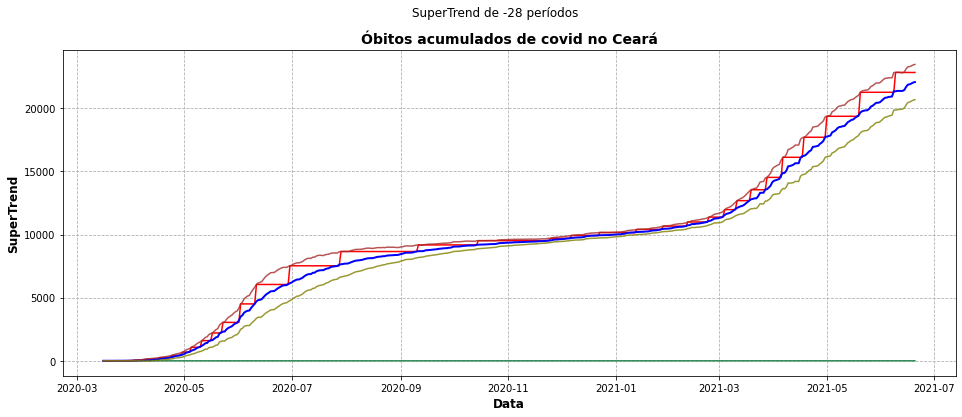

In [ ]:
plotar_supertrend(dados_CE, 'Ultimas_mortes', 'Óbitos acumulados de covid no Ceará',
                  periodos = -28, unidade =7, multiplicador1 = 2, multiplicador2 = 2, mostrar_bandas_basicas = True)

Novamente, observe como ele captura muito bem esses pontos onde a taxa de crescimento sofre um aumento. 

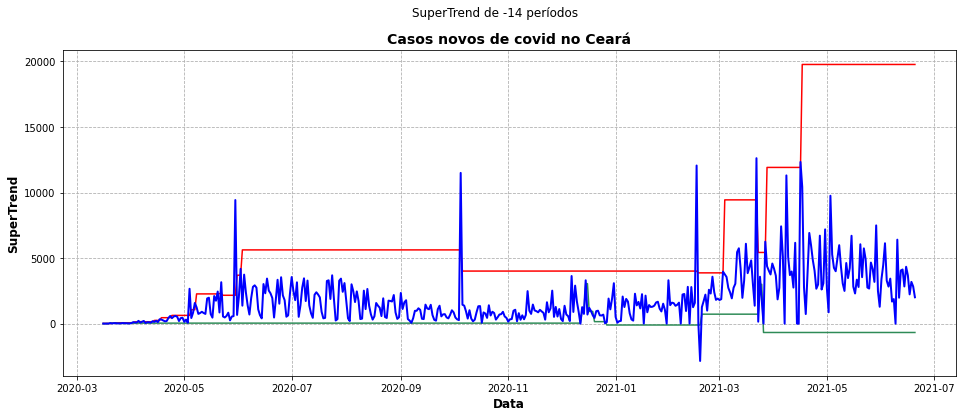

In [ ]:
plotar_supertrend(dados_CE, 'Novos_casos', 'Casos novos de covid no Ceará',
                  periodos = -14, unidade =7, multiplicador1 = 1, multiplicador2 = 0.1, mostrar_bandas_basicas = False)

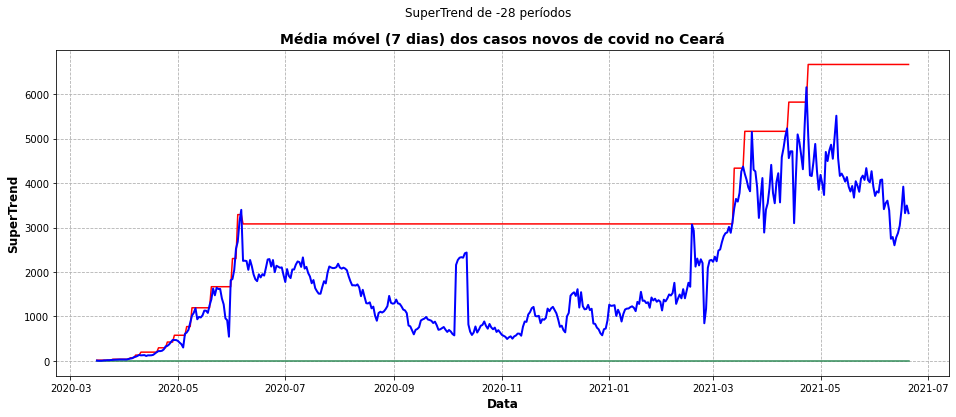

In [ ]:
plotar_supertrend(dados_CE, 'MM7_casos_novos', 'Média móvel (7 dias) dos casos novos de covid no Ceará',
                  periodos = -28, unidade =7, multiplicador1 = 1, multiplicador2 = 1, mostrar_bandas_basicas = False)

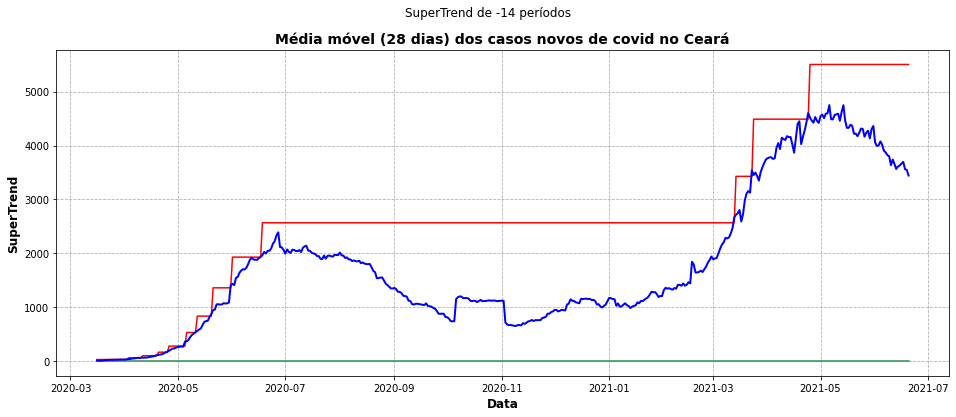

In [ ]:
plotar_supertrend(dados_CE, 'MM28_casos_novos', 'Média móvel (28 dias) dos casos novos de covid no Ceará',
                  periodos = -14, unidade = 7, multiplicador1 = 2, multiplicador2 = 1, mostrar_bandas_basicas = False)

Vemos que para os casos novos diários, o indicador não está funcionando muito bem no vale que existe entre Julho de 2020 e Março de 2021. No entanto, a última banda nos dá a próxima resistência: por volta de 5 mil casos. Isso significa, em teoria, que se o gráfico cruzar esse limiar, a tendência é crescer ainda mais. 

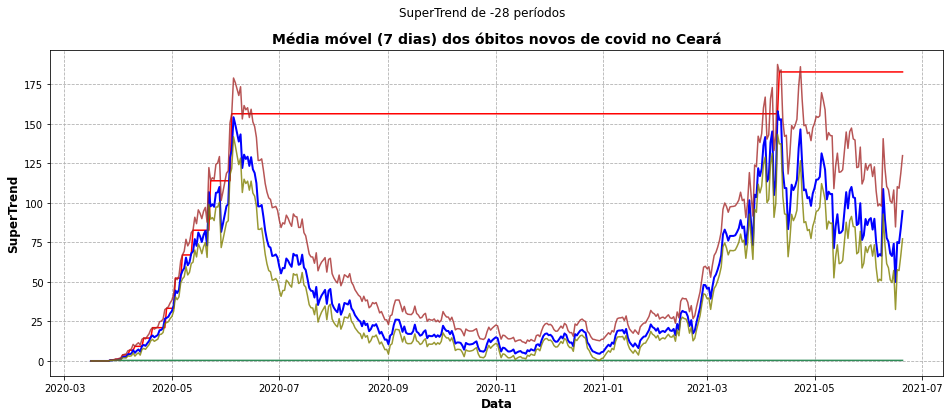

In [ ]:
plotar_supertrend(dados_CE, 'MM7_obitos_novos', 'Média móvel (7 dias) dos óbitos novos de covid no Ceará',
                  periodos = -28, unidade = 7, multiplicador1 = 1, multiplicador2 = 0.5, mostrar_bandas_basicas = True)

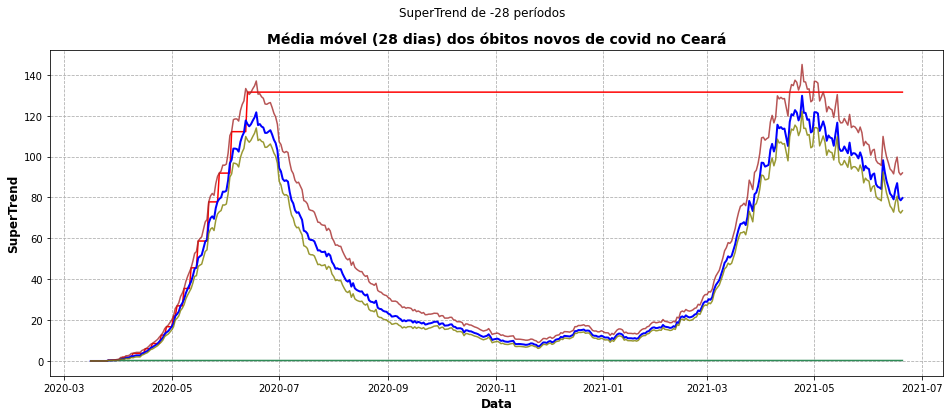

In [ ]:
plotar_supertrend(dados_CE, 'MM28_obitos_novos', 'Média móvel (28 dias) dos óbitos novos de covid no Ceará',
                  periodos = -28, unidade = 7, multiplicador1 = 1, multiplicador2 = 0.5, mostrar_bandas_basicas = True)

Já para as mortes diárias, o gráfico da média móvel de 28 ainda não cruzou o último limite, em aproximadamente 130 casos.

Vejamos esse mesmo indicador para os dados resumidos por semana epidemiológica:

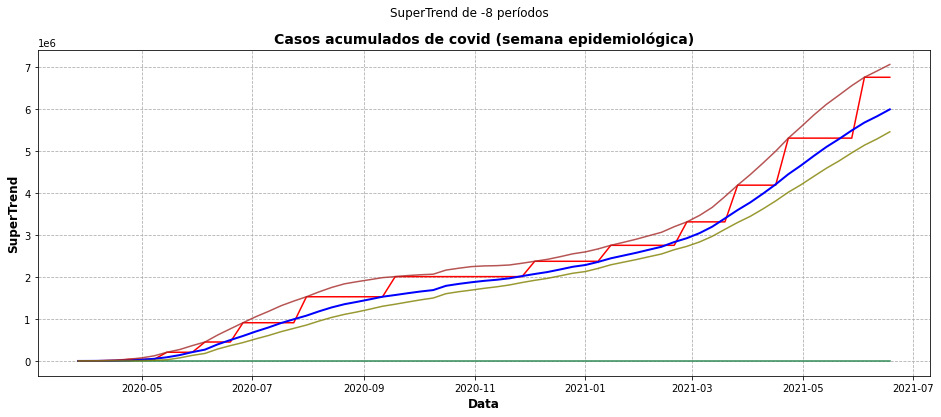

In [ ]:
plotar_supertrend(dados_sem_CE, 'Ultimos_confirmados', 'Casos acumulados de covid (semana epidemiológica)', v_tempo= 'Semana_epi', 
                  periodos = -8, unidade = 2, multiplicador1 = 2, multiplicador2 = 1, mostrar_bandas_basicas = True)

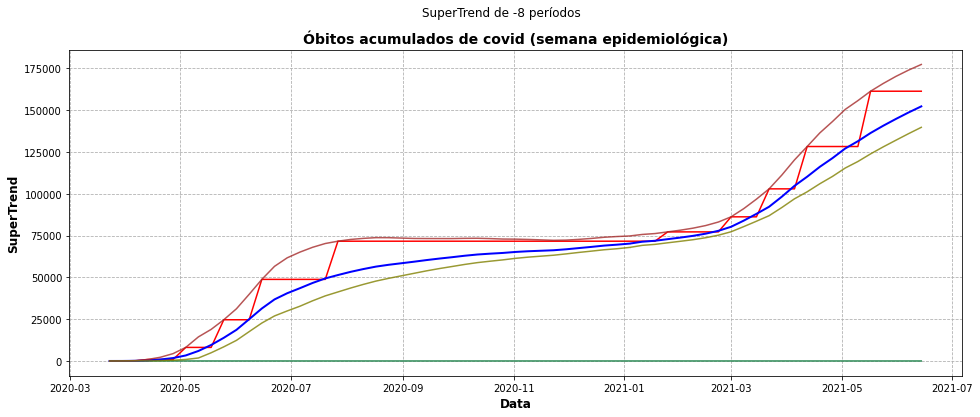

In [ ]:
plotar_supertrend(dados_sem_CE, 'Ultimas_mortes', 'Óbitos acumulados de covid (semana epidemiológica)', v_tempo= 'Semana_epi', 
                  periodos = -8, unidade = 2, multiplicador1 = 2, multiplicador2 = 1, mostrar_bandas_basicas = True)

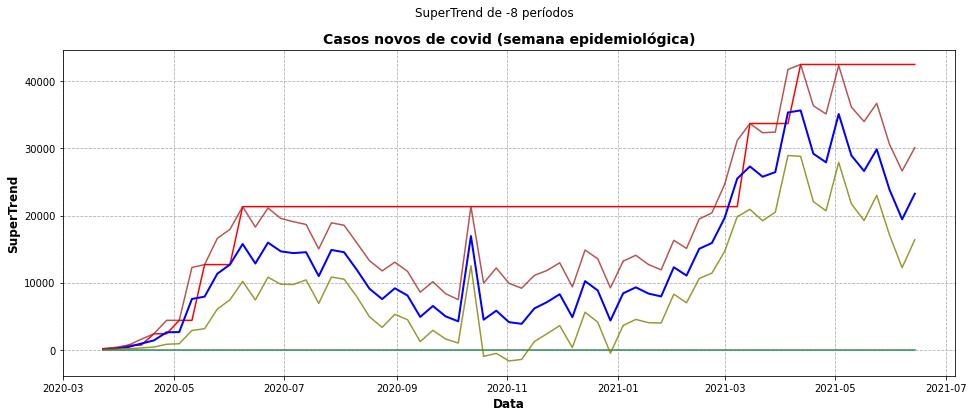

In [ ]:
plotar_supertrend(dados_sem_CE, 'Novos_casos', 'Casos novos de covid (semana epidemiológica)', v_tempo= 'Semana_epi', 
                  periodos = -8, unidade = 2, multiplicador1 = 1, multiplicador2 = 1, mostrar_bandas_basicas = True)

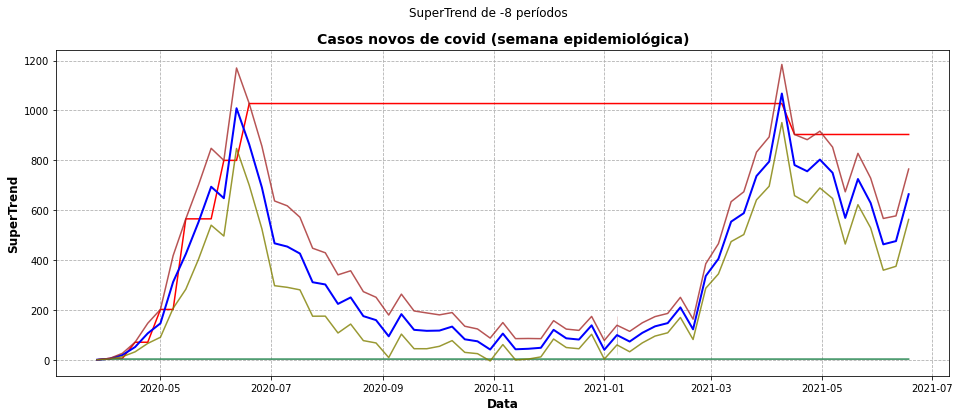

In [ ]:
plotar_supertrend(dados_sem_CE, 'Novas_mortes', 'Casos novos de covid (semana epidemiológica)', v_tempo= 'Semana_epi', 
                  periodos = -8, unidade = 2, multiplicador1 = 0.5, multiplicador2 = 0.5, mostrar_bandas_basicas = True)

# Cruzamento de médias móveis

Por fim, vamos utilizar o cruzamento de médias móveis para identificar pontos de virada e reversões de tendência. Como explicado na introdução, temos duas médias móveis, uma curta e outra longa. Toda vez que a média curta cruza a longa para cima, temos indicativo de início tendência de alta. Se cruza para baixo, é indicativo de tendência de baixa.

A função definia da segunda sessão plota o gráfico da série, juntamente com suas médias móveis e retas verticais indicando onde ocorreu os cruzamentos. Retas verdes indicam cruzamento para cima (tendência de alta) e retas marrons indicam cruzamento para baixo (tendência de baixa). A primeira e a última retas sempre são verdes, e não significam nada mais que o início e o fim da série. Em nosso estudo, sempre vamos considerar a média curta de 14 períodos e a média longa de 60 períodos. 
Vejamos:

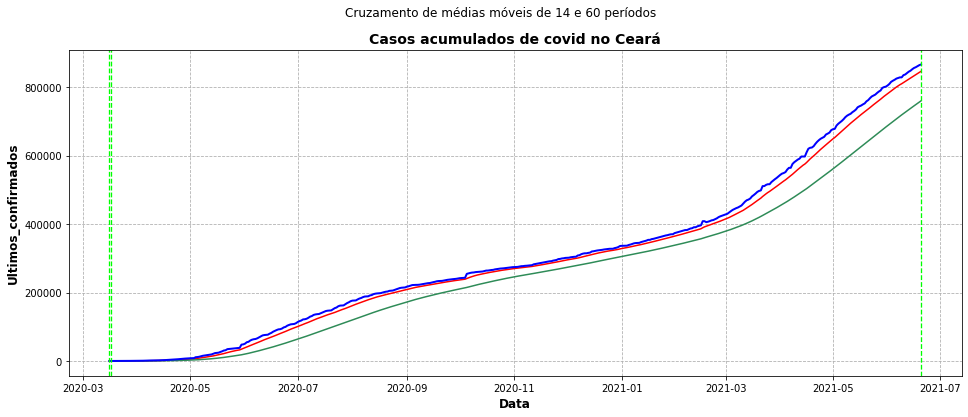

In [ ]:
cruzar_medias_moveis(dados_CE, 'Ultimos_confirmados', 'Casos acumulados de covid no Ceará', periodo1= 14, periodo2= 60)

Para os casos acumulados, não funcionou muito bem. Isso porque esses dados estão sempre em alta, e apresentam pouca volatilidade. O cruzamento de médias móveis funciona melhor quando a série é mais volátil.

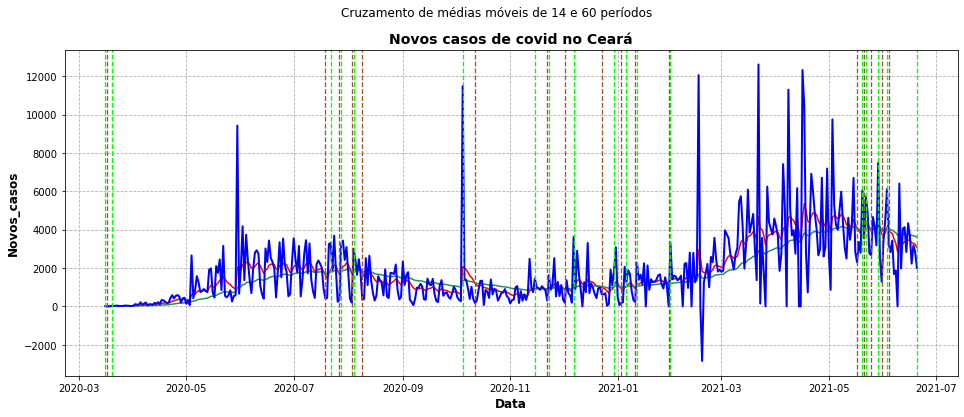

In [ ]:
cruzar_medias_moveis(dados_CE, 'Novos_casos', 'Novos casos de covid no Ceará', periodo1= 14, periodo2= 60)

Para os casos novos, parece uma bagunça, com sinais de alta intercalados com sinais de baixa em um curto espaço de tempo. Melhor olhar para as médias móveis (sim, vamos calcular médias móveis de médias móveis).

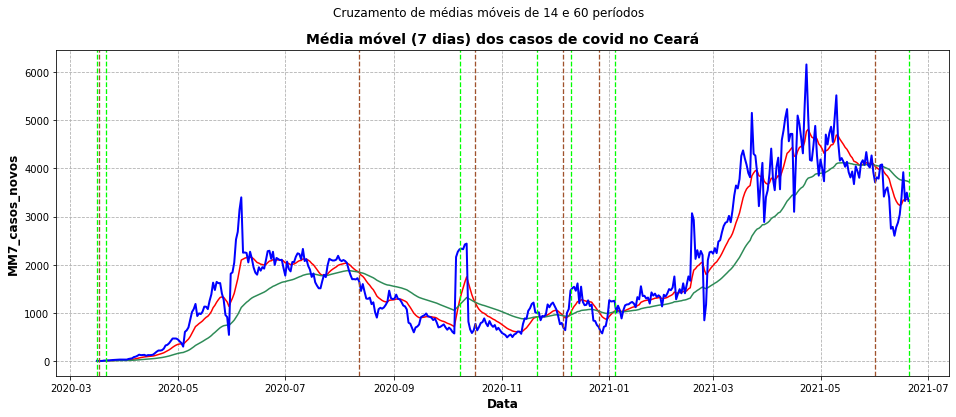

In [ ]:
cruzar_medias_moveis(dados_CE, 'MM7_casos_novos', 'Média móvel (7 dias) dos casos de covid no Ceará', periodo1= 14, periodo2= 60)

Agora temos algo mais interessante. Observe que, segundo esse gráfico, estamos atualmente em tendência de baixa, como já discutido antes. E apesar da leve alta nos últimos dias, a média móvel curta (em vermelho) ainda está bem abaixo da média móvel longa (em verde). Então a tendência de baixa se mantém firme, pelo menos por enquanto. 

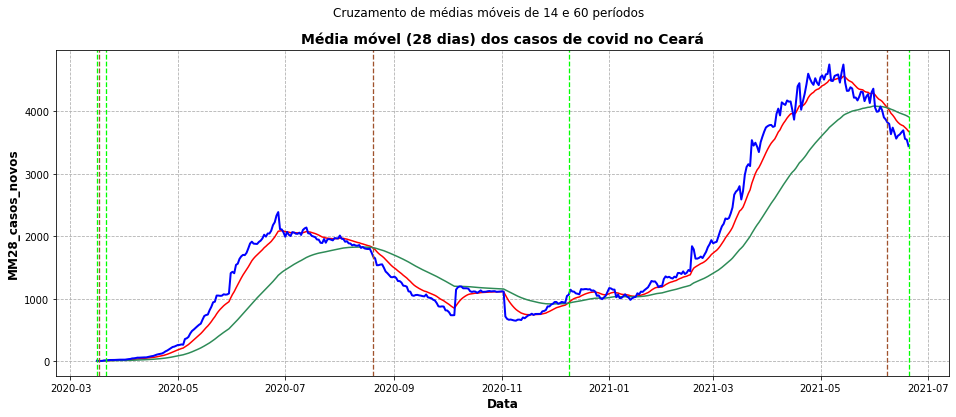

In [ ]:
cruzar_medias_moveis(dados_CE, 'MM28_casos_novos', 'Média móvel (28 dias) dos casos de covid no Ceará', periodo1= 14, periodo2= 60)

Vejamos agora os óbitos novos:

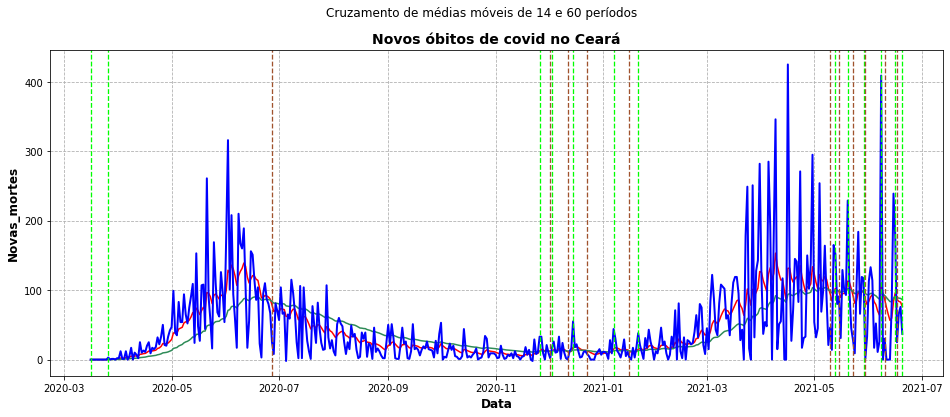

In [ ]:
cruzar_medias_moveis(dados_CE, 'Novas_mortes', 'Novos óbitos de covid no Ceará', periodo1= 14, periodo2= 60)

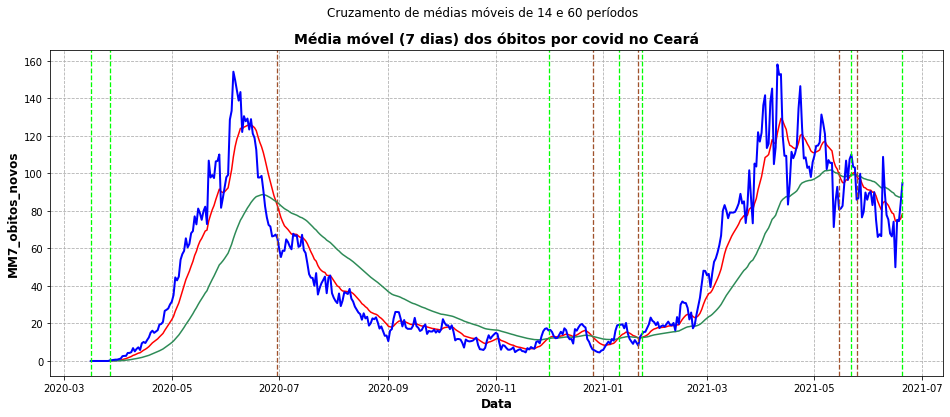

In [ ]:
cruzar_medias_moveis(dados_CE, 'MM7_obitos_novos', 'Média móvel (7 dias) dos óbitos por covid no Ceará', periodo1= 14, periodo2= 60)

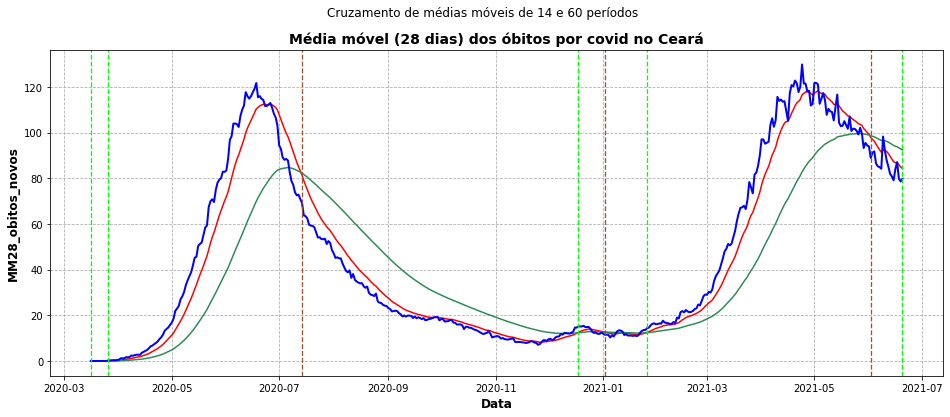

In [ ]:
cruzar_medias_moveis(dados_CE, 'MM28_obitos_novos', 'Média móvel (28 dias) dos óbitos por covid no Ceará', periodo1= 14, periodo2= 60)

Assim como nos casos novos diários, as mortes diárias estão em tendência de baixa. 

## Aproximação poligonal

Também foi criada uma função de aproximação poligonal tendo como base os pontos onde as médias móveis se cruzam. Vejamos:

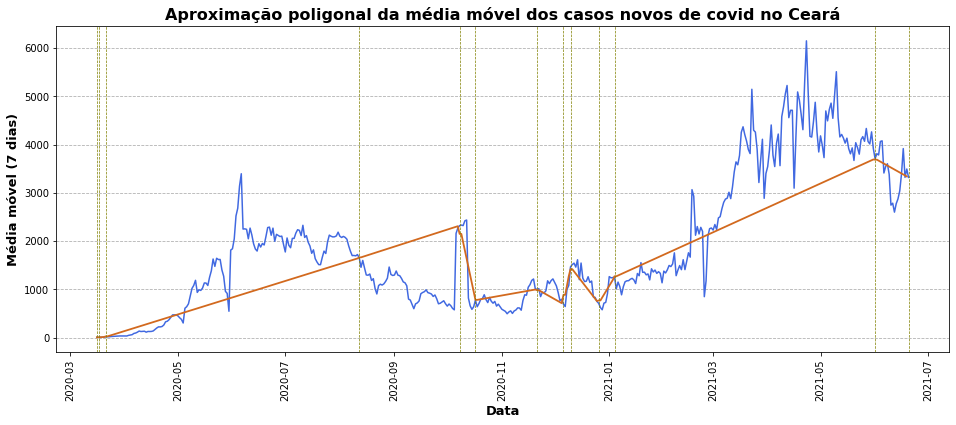

In [ ]:
plotar_aproximacao_poligonal_medias(dados_CE, 'MM7_casos_novos', 'Média móvel (7 dias)',
                                    'Aproximação poligonal da média móvel dos casos novos de covid no Ceará',
                                    periodo1 = 14, periodo2 = 60)

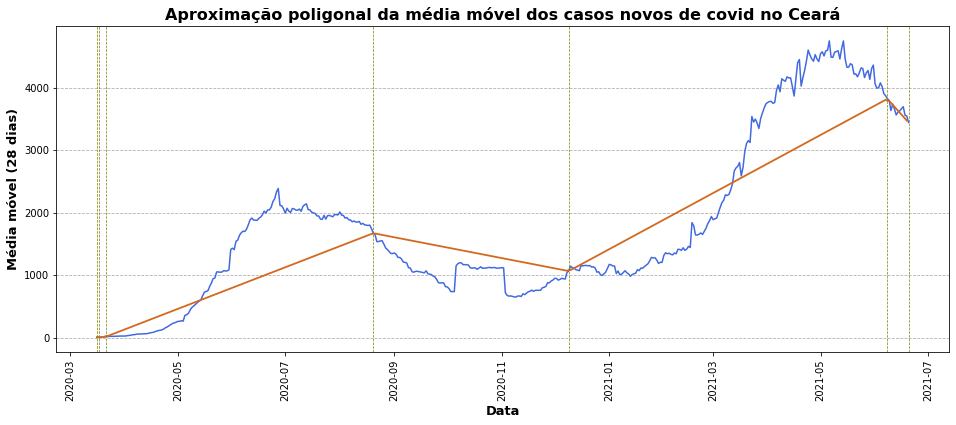

In [ ]:
plotar_aproximacao_poligonal_medias(dados_CE, 'MM28_casos_novos', 'Média móvel (28 dias)',
                                    'Aproximação poligonal da média móvel dos casos novos de covid no Ceará',
                                    periodo1 = 14, periodo2 = 60)

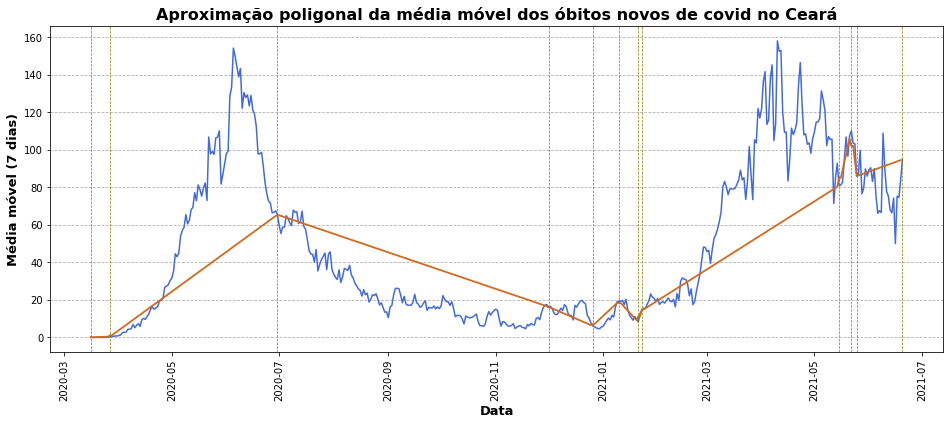

In [ ]:
plotar_aproximacao_poligonal_medias(dados_CE, 'MM7_obitos_novos', 'Média móvel (7 dias)',
                                    'Aproximação poligonal da média móvel dos óbitos novos de covid no Ceará',
                                    periodo1 = 14, periodo2 = 60)

# Conclusão final e trabalhos futuros

O principal ponto observado ao longo desse trabalho, e que foi confirmado pelas análise é esse:

**Os casos novos diários e óbitos novos diários de covid no estado do Ceará estão em tendência de queda, quebrando uma forte onda de alta.** 

Não dá para confirmar se essa tendência se manterá ou por quanto tempo. Hipóteses levantadas:
- Consequência da campanha de vacinação, que está avançando rápido no estado.
- Dados incompletos. 

Nenhuma dessas hipóteses foi testada nesse projeto, mas poderá ser tema de estudos futuros. 


Outros temas relacionados que podem vir a ser trabalhados em futuros projetos:
- Analisar o impacto das medidas de isolamento social nos casos novos diários. 
- Desenvolver um projeto contínuo de análise e previsão de novos casos, usando o Prophet e as técnicas discutidas nesse notebook, atualizado semanalmente. Divulgar os resultados em alguma mídia. 
- Analisar o impacto da covid nos diversos setores econômicos. 
- Fazer a mesma análise a nível municipal. O município escolhido será Caucaia, minha cidade natal.

Além dos projetos em si, pretendo trabalhar mais nas funções aqui desenvolvidas, para melhorar seus códigos. Dentre as melhorias já planejadas:
- Criar uma função que plota a aproximação poligonal, tendo como base os pontos de virada identificados pelo SuperTrend.
- Para as funções que plotam os pontos de virada, criar um hiperparâmetro novo, que receberá uma lista de datas. A função também plotará essas datas junto com os pontos de viradas e será possível comparar os dois conjuntos de datas. Isso será útil, por exemplo, para estudar o impacto do isolamento social. Na lista de datas podemos inserir as datas de início e término dos lockdowns e ver se eles coincidem com algum ponto de virada. 
- Melhorar o código das funções TR, ATR e SuperTrend, que ainda não estão se comportado como deveriam. 